# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# →🪴Selfnotes
## Linear Regression not predicting items separately
❌ I thought that if I trained all the items in 1 model and use the items as categorical one-hot encoding, that the model would make predictions separately, which is wrong. When I trained them all in 1 model, the prediction of items affect each other. ✅ I trained separate models and pipes on each item separately, then I have an object where I use the model for a specific item to make predictions.❓I am still confused why my approach is making weird predictions. 👉 Need to focus on GROCERY I again and see how I can improve that first.

## Zero Days makes it weird
❌ There are some days with zero sales in some products, which is affects the predictions because it is averaging things out. This results to negative predictions. ✅ I dropped the zero days and the models are making predictions properly. ❓But I am still not sure how to integrate this to the pipeline. 👉I need to focus on BOOKS and see how to integrate with pipes.

## 🐜I am almost there
My predictions are still off. But I am almost there. You are starting to think the python way. You are using models and pipes are as objects. You are almost here. You just need to keep focus.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

## Clean
transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

def cleanData(a):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_type'] = a['store_nbr'].map(store_type)
    return a

df = cleanData(df)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# → Feature Prime
Point me in the right direction. Sales is the target and onpromotion is the feature that I need to focus on since it is the one that is highly correlated to Sales.

In [2]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

sales          1.000000
onpromotion    0.379903
id             0.083456
year           0.077355
store_nbr      0.037881
dayofyear      0.034132
weeknum        0.032397
Name: sales, dtype: float64

# → Beating the Average
If I just used the average, what would it look like? The model that I will build must be better than the average. What the hell is the point if I cannot be better than the average.

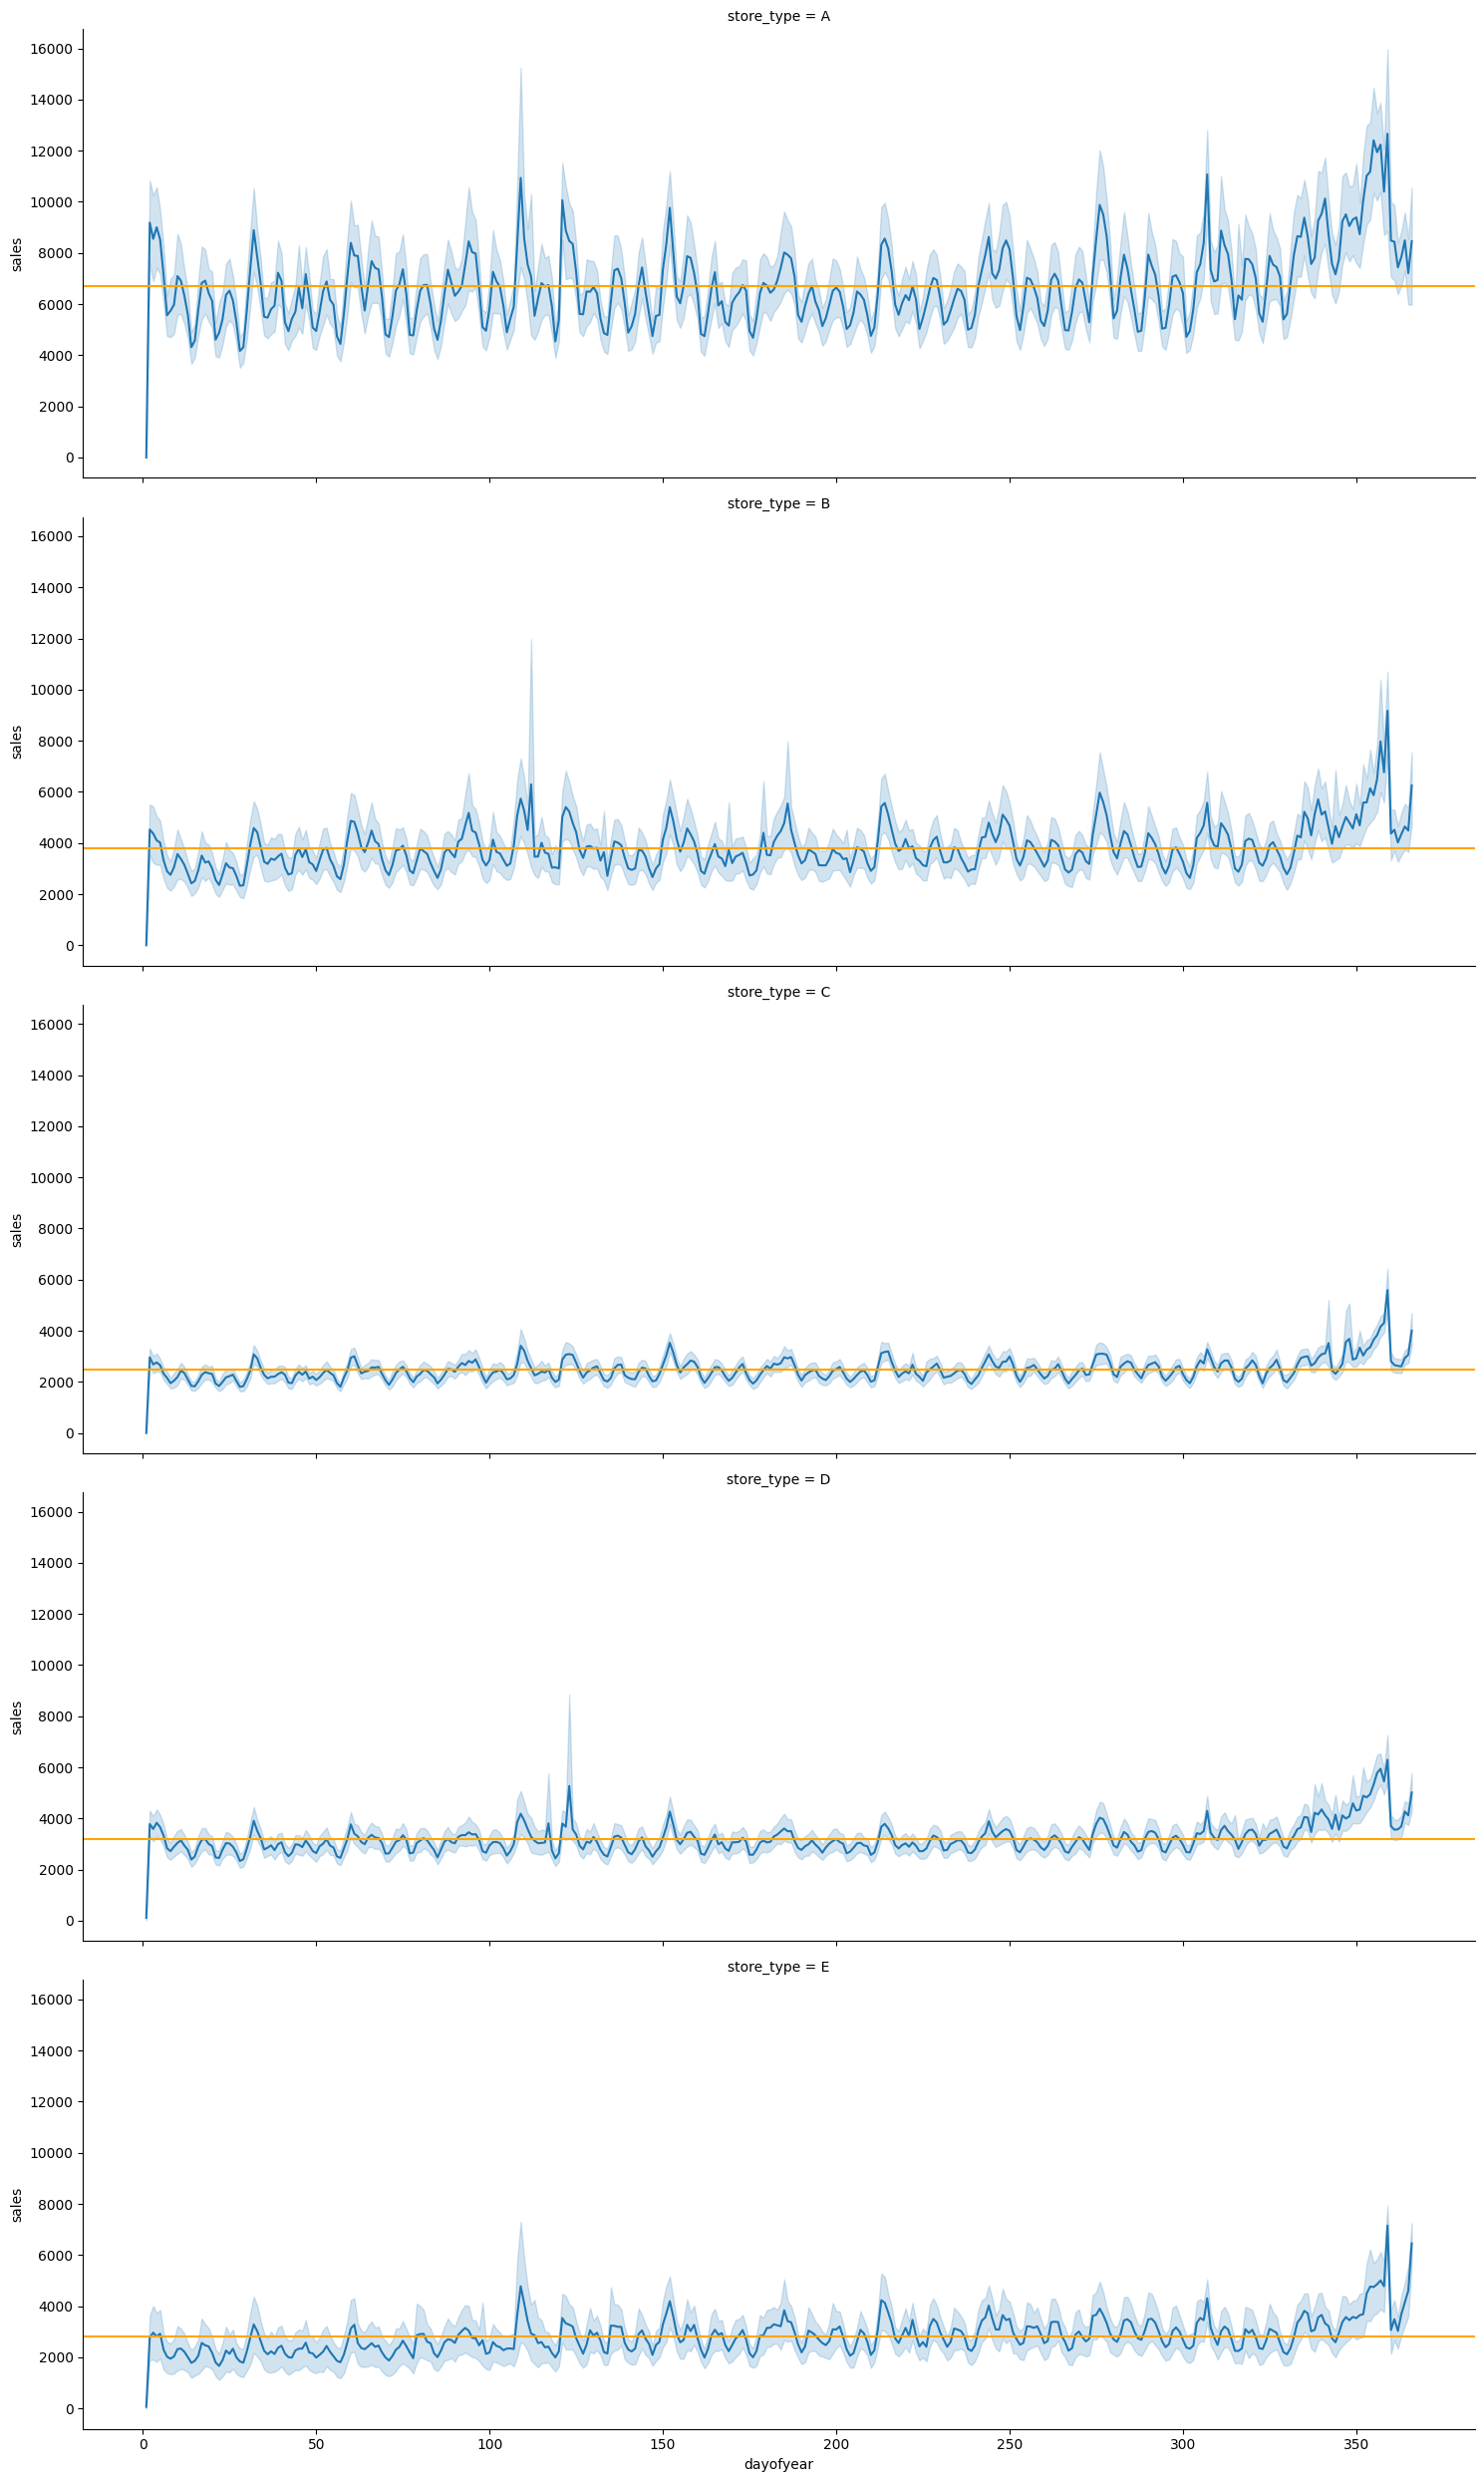

In [3]:
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# → Low volume low volatility items
I need to figure out how to add zeros and ones to items that are insignificant like Books. The model is predicting variability that are applicable to the high volume items like groceries but in reality books are 1s and 0s. How?

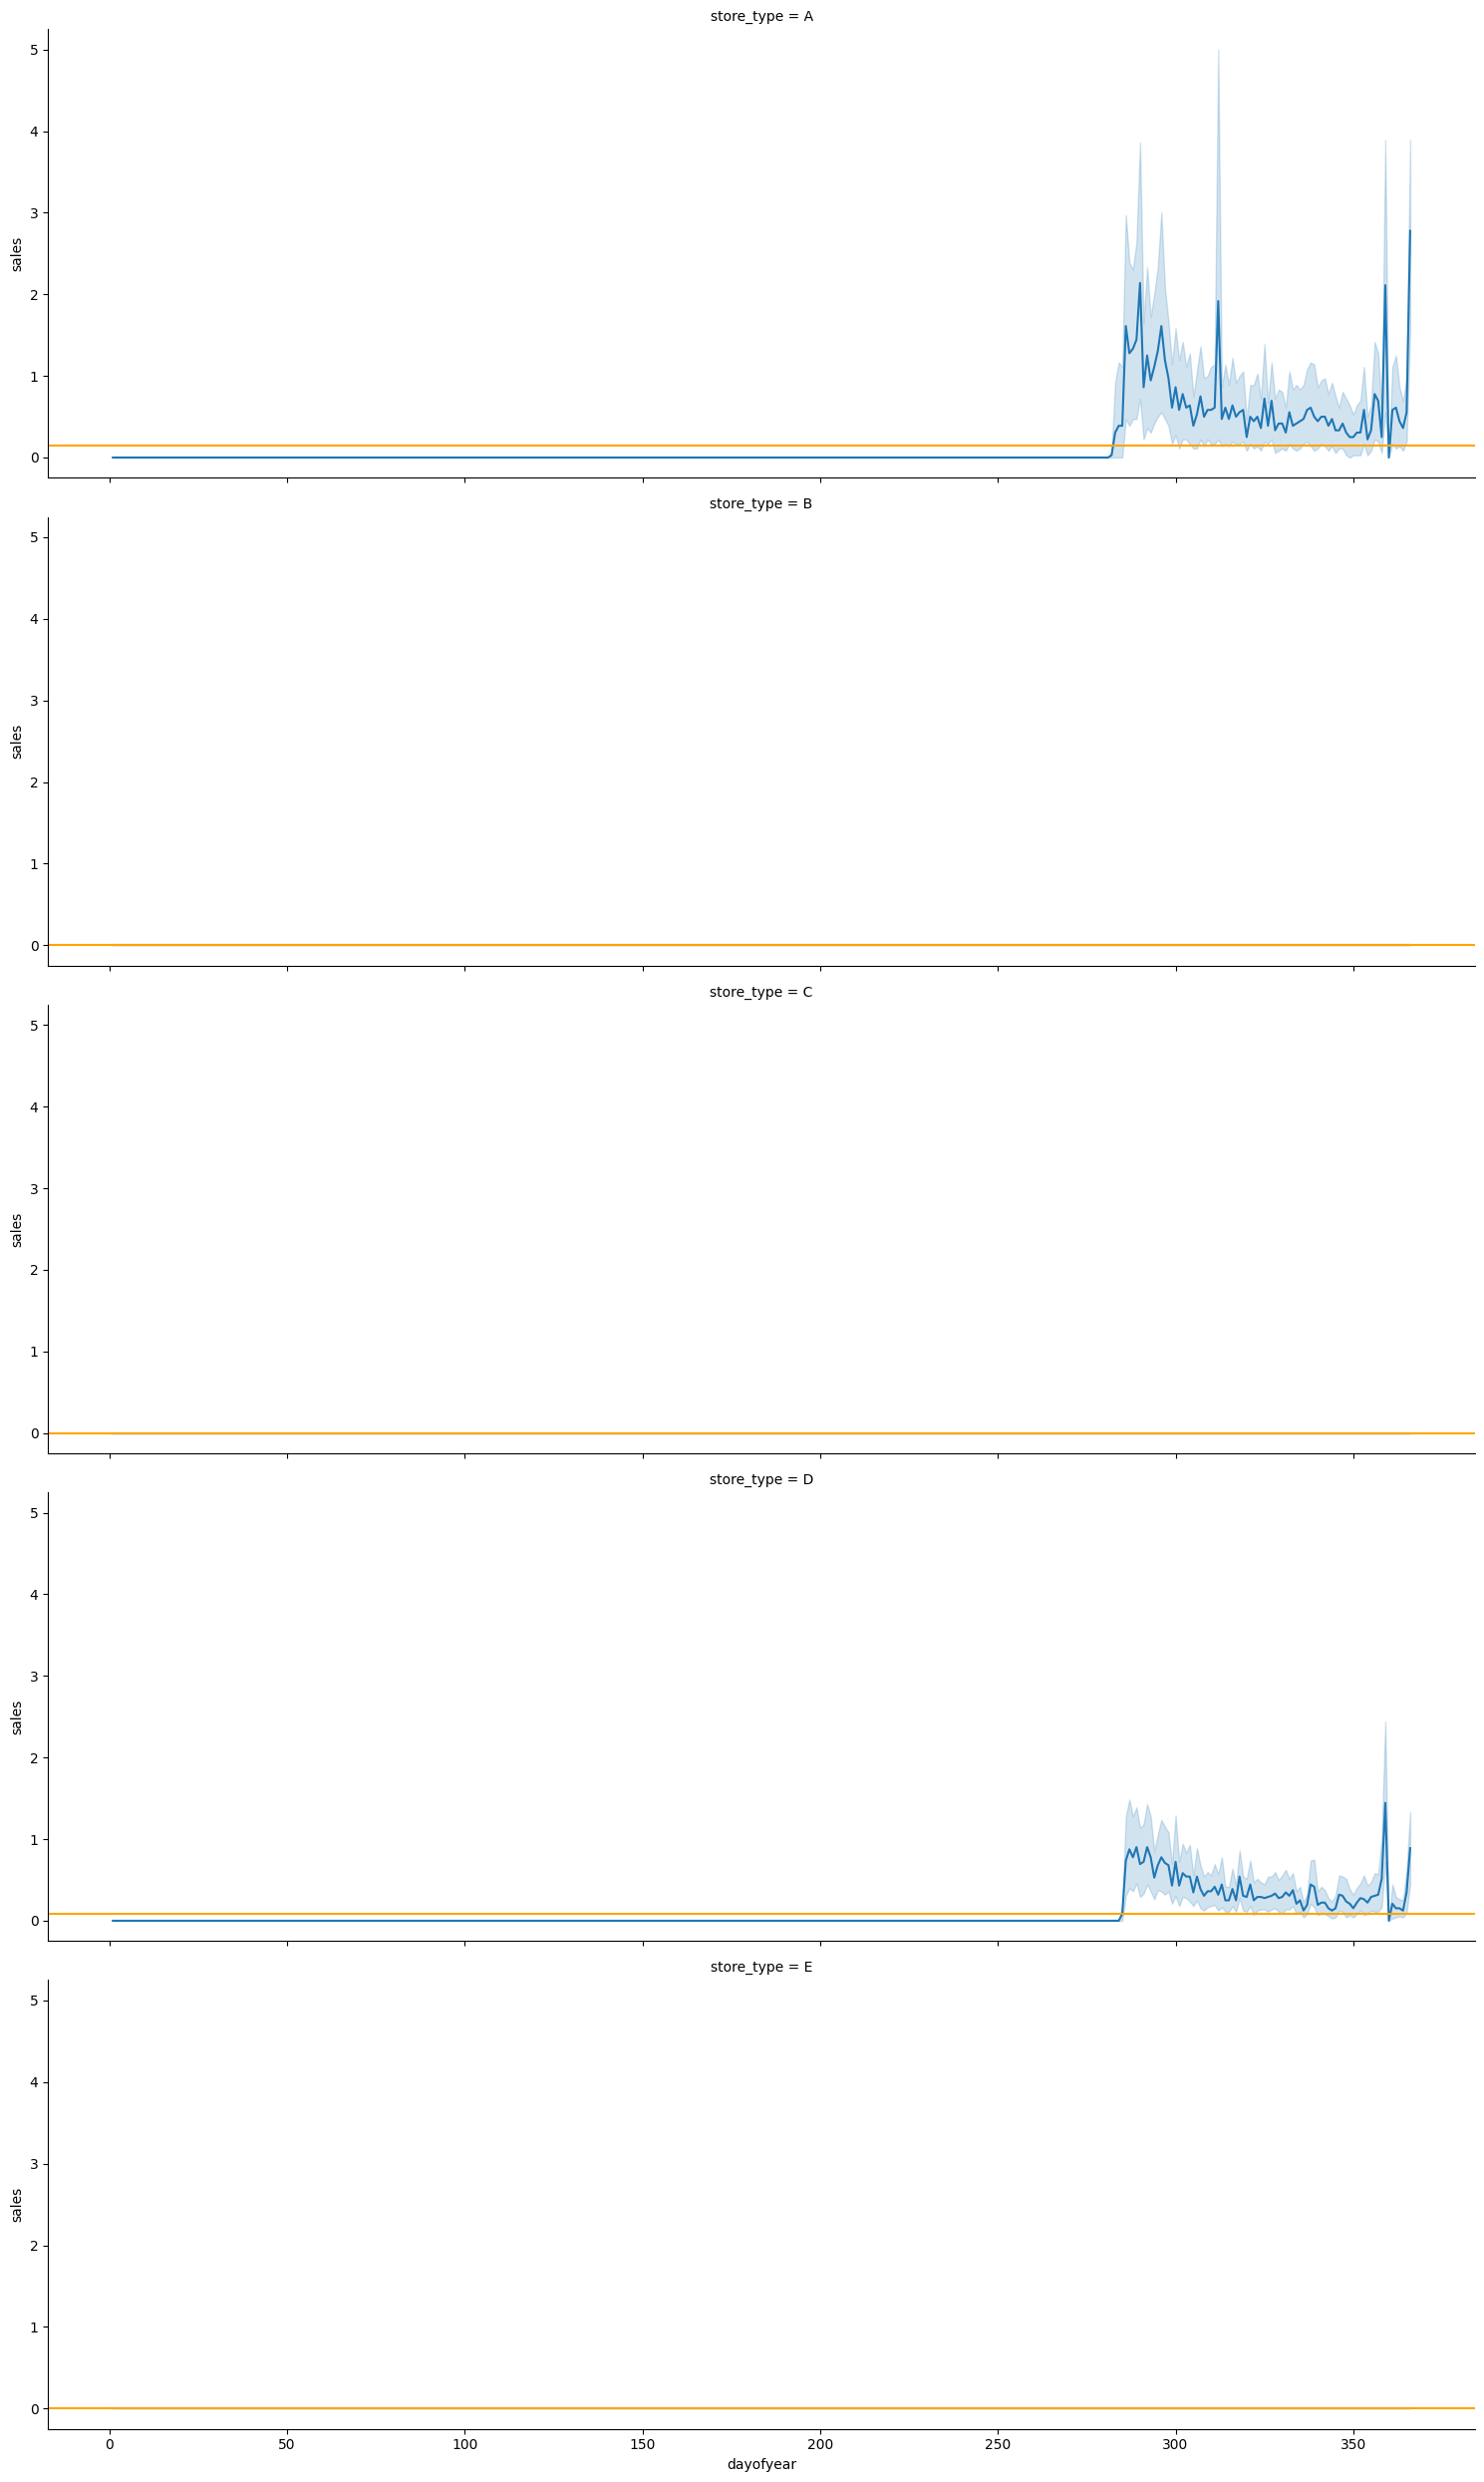

In [4]:
d = train.query("family== 'BOOKS'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

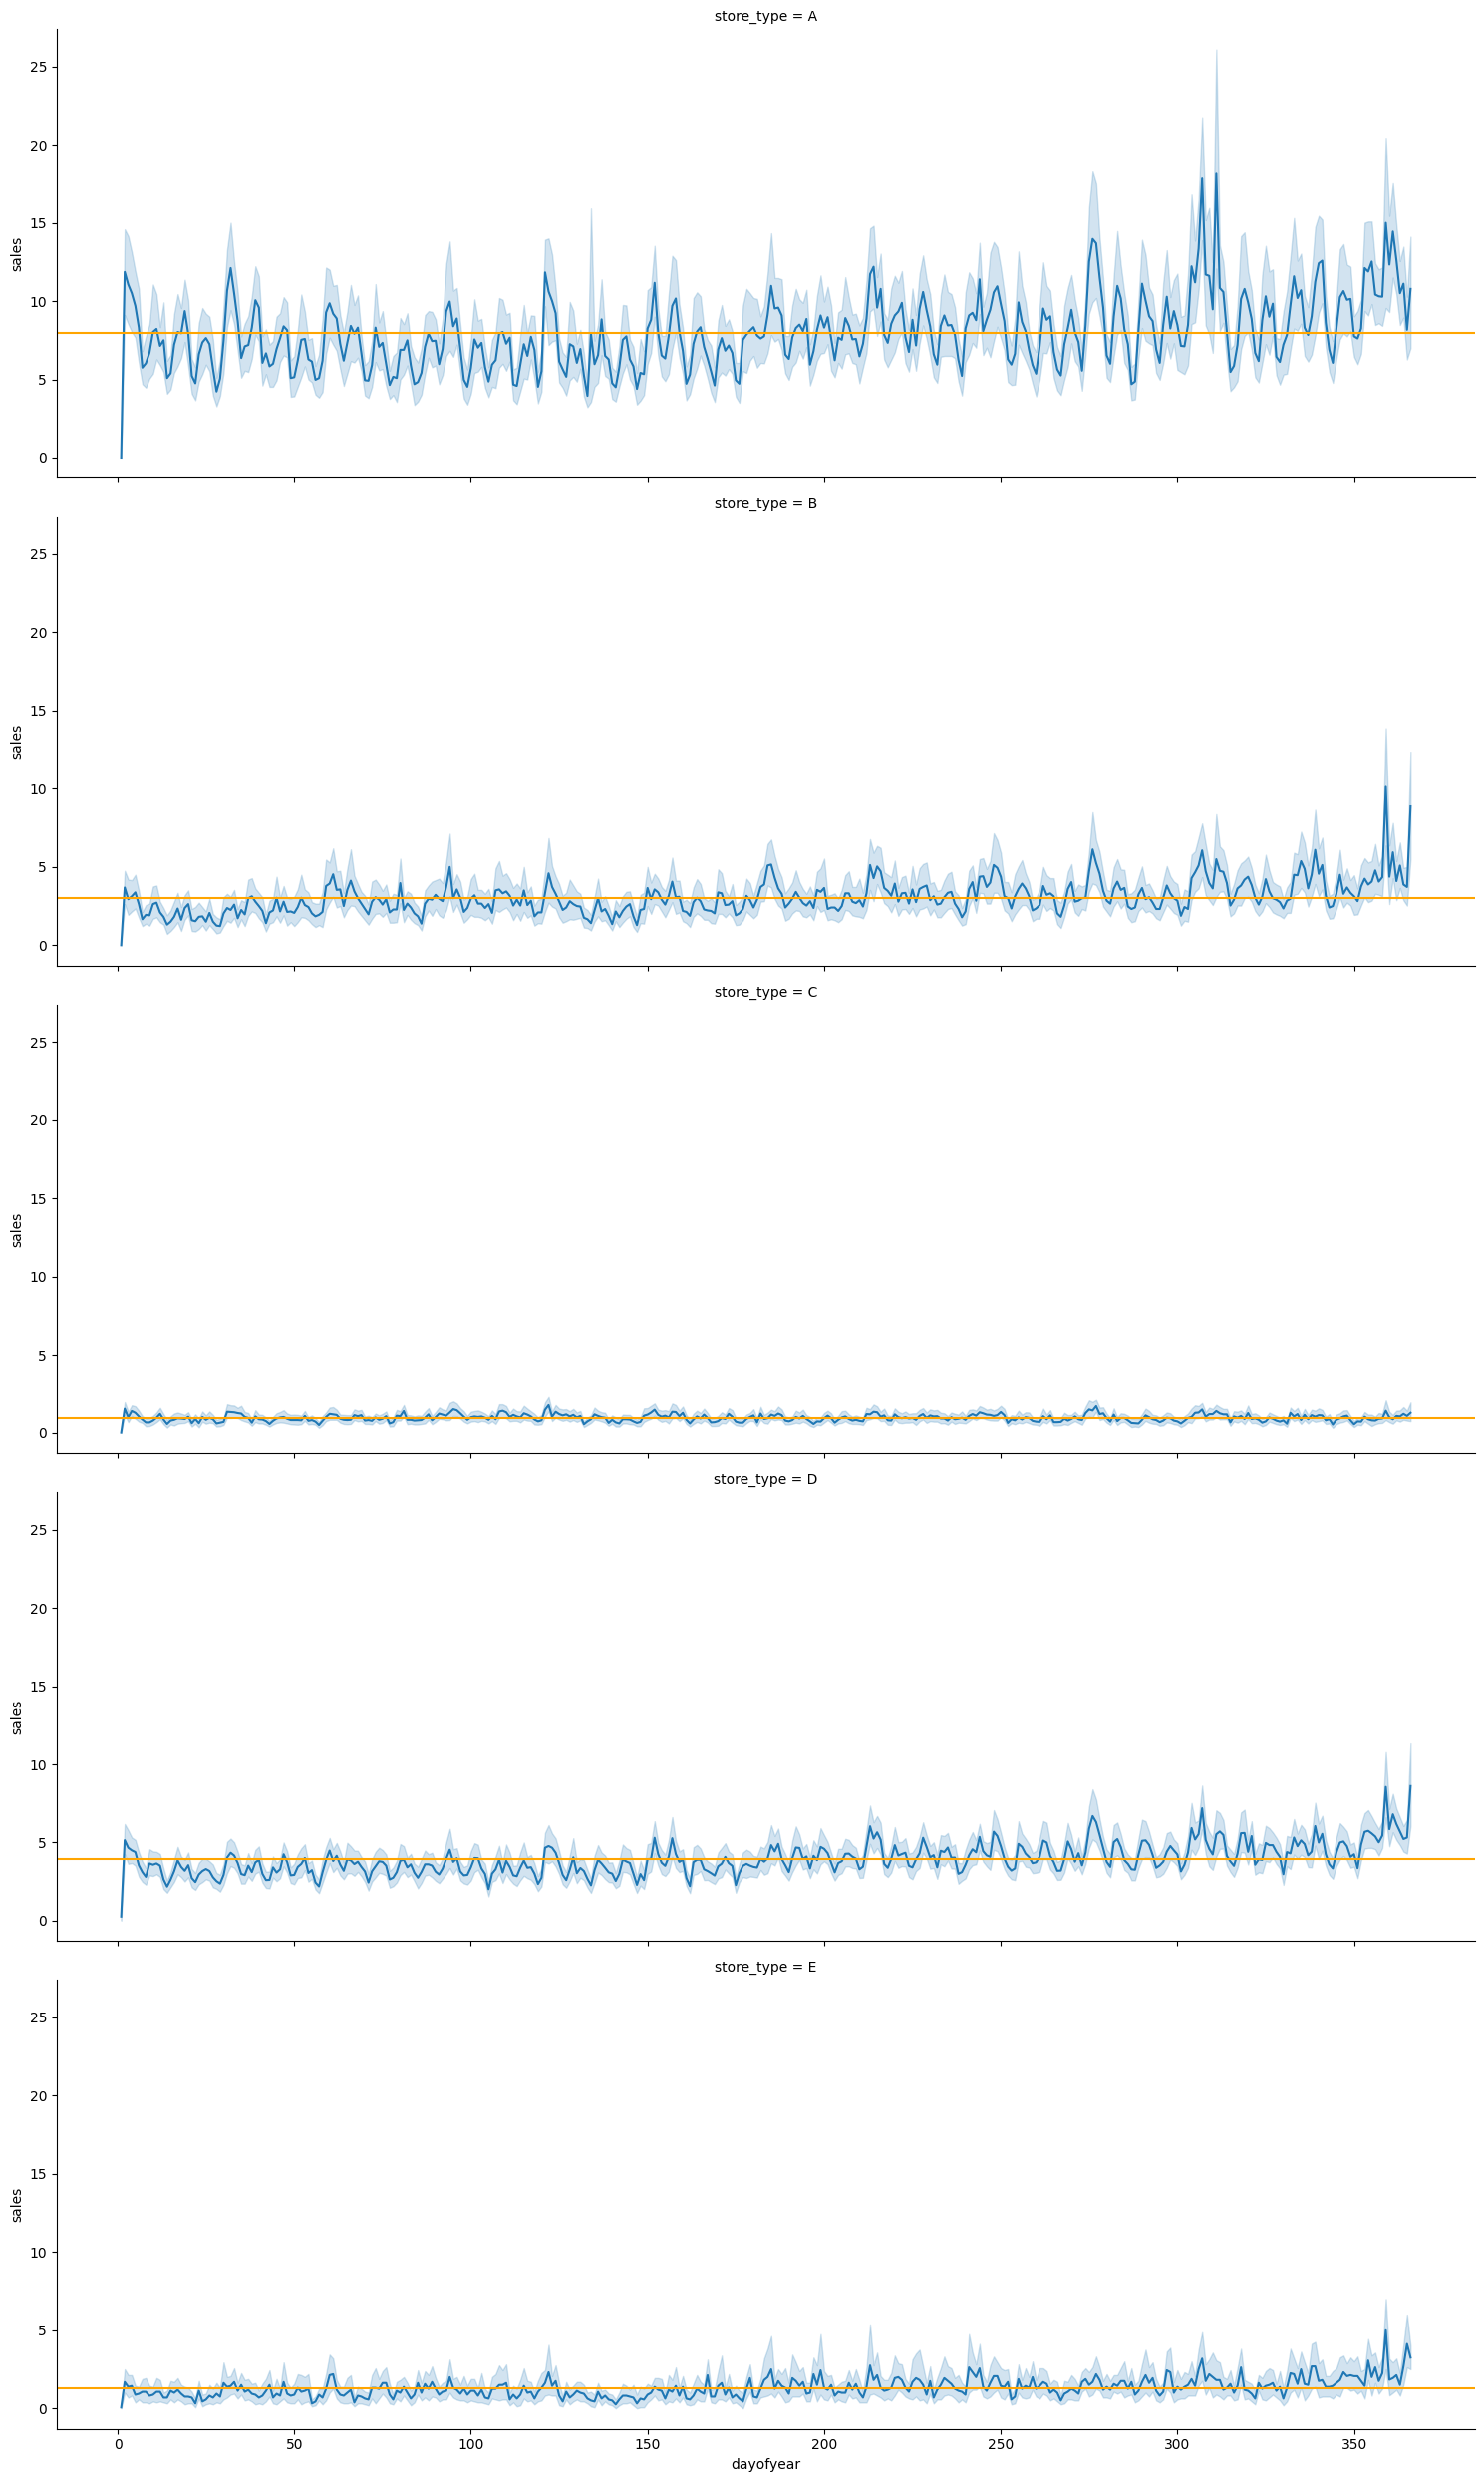

In [5]:
d = train.query("family== 'BEAUTY'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

# → Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [6]:
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

,sum,std
family,,
GROCERY I,8.795437e+07,4002.821565
BEVERAGES,5.735129e+07,3320.277867
PRODUCE,3.531288e+07,3546.392141
CLEANING,2.368491e+07,987.190292
DAIRY,1.913834e+07,922.703547
POULTRY,1.104872e+07,562.829831
BREAD/BAKERY,1.064485e+07,480.295143
MEATS,1.041856e+07,443.761820
PERSONAL CARE,6.373462e+06,338.781103


# 🤖Model

# → Pipes

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = cleanData(X) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion', 'weeknum']))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['weekname']))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

FeatureUnion(transformer_list=[('numeric',
                                Pipeline(steps=[('dataselect',
                                                 DataSelect(att=['onpromotion',
                                                                 'weeknum'])),
                                                ('impute', SimpleImputer()),
                                                ('scaler', StandardScaler())])),
                               ('cat',
                                Pipeline(steps=[('dataselect',
                                                 DataSelect(att=['weekname'])),
                                                ('encoder',
                                                 OneHotEncoder(handle_unknown='ignore',
                                                               sparse_output=False))]))])

# → Baseline

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
# reg_lin = LinearRegression()
# reg_lin.fit(train_pp, train[target])

In [10]:
def trainModels(d):
    ms = {}
    ps = {}
    for member in d['family'].unique():
        for store_type in d['store_type'].unique():
            m = LinearRegression()
            tr = d.loc[(d['family'] == member) & (d['store_type'] == store_type)]
            p = pipe.fit(tr)
            x = p.transform(tr)
            y = tr[target]

            m.fit(x, y)
            ms[member + "|" + store_type] = m
            ps[member + "|" + store_type] = p
        
    return ms, ps

In [11]:
models, pipes = trainModels(train)

In [12]:
def makePredictions(d, m, p):
    mem = d['family'].iloc[0] + "|" + d['store_type'].iloc[0]
    x = p[mem].transform(d)
    return pd.Series(m[mem].predict(x))

In [13]:
# train['preds'] = 
g = train#.query('family == "GROCERY I" and store_type == "A"')

g = g.groupby(['family', 'store_type']).apply(makePredictions, models, pipes).reset_index(drop=True)
g

0          9.274118
1          9.274118
2          9.274118
3          9.274118
4          9.274118
             ...   
2596369    1.343481
2596370    3.451808
2596371    3.451808
2596372    1.470679
2596373    1.470679
Length: 2596374, dtype: float64

In [14]:
train['preds'] = train.groupby(['family', 'store_type']).apply(makePredictions, models, pipes).reset_index(drop=True)

# → Residuals. Make orange closer to blue dots.

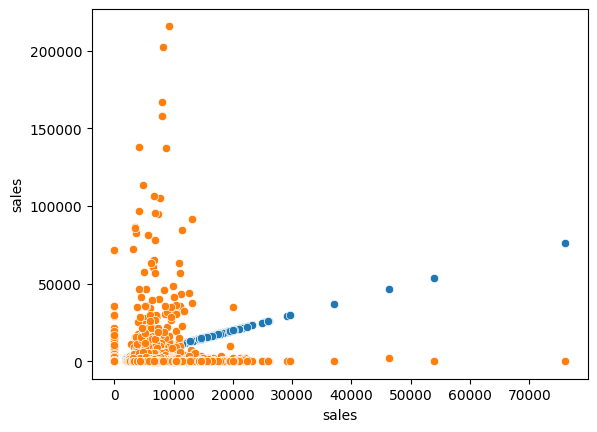

In [15]:
g = train.query('family == "GROCERY I" and store_type == "A"')
x = g[target]
y = g['preds']
sns.scatterplot(x=x,y=x);
sns.scatterplot(x=x,y=y);
# improve this. you are in the right direction.

# → Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

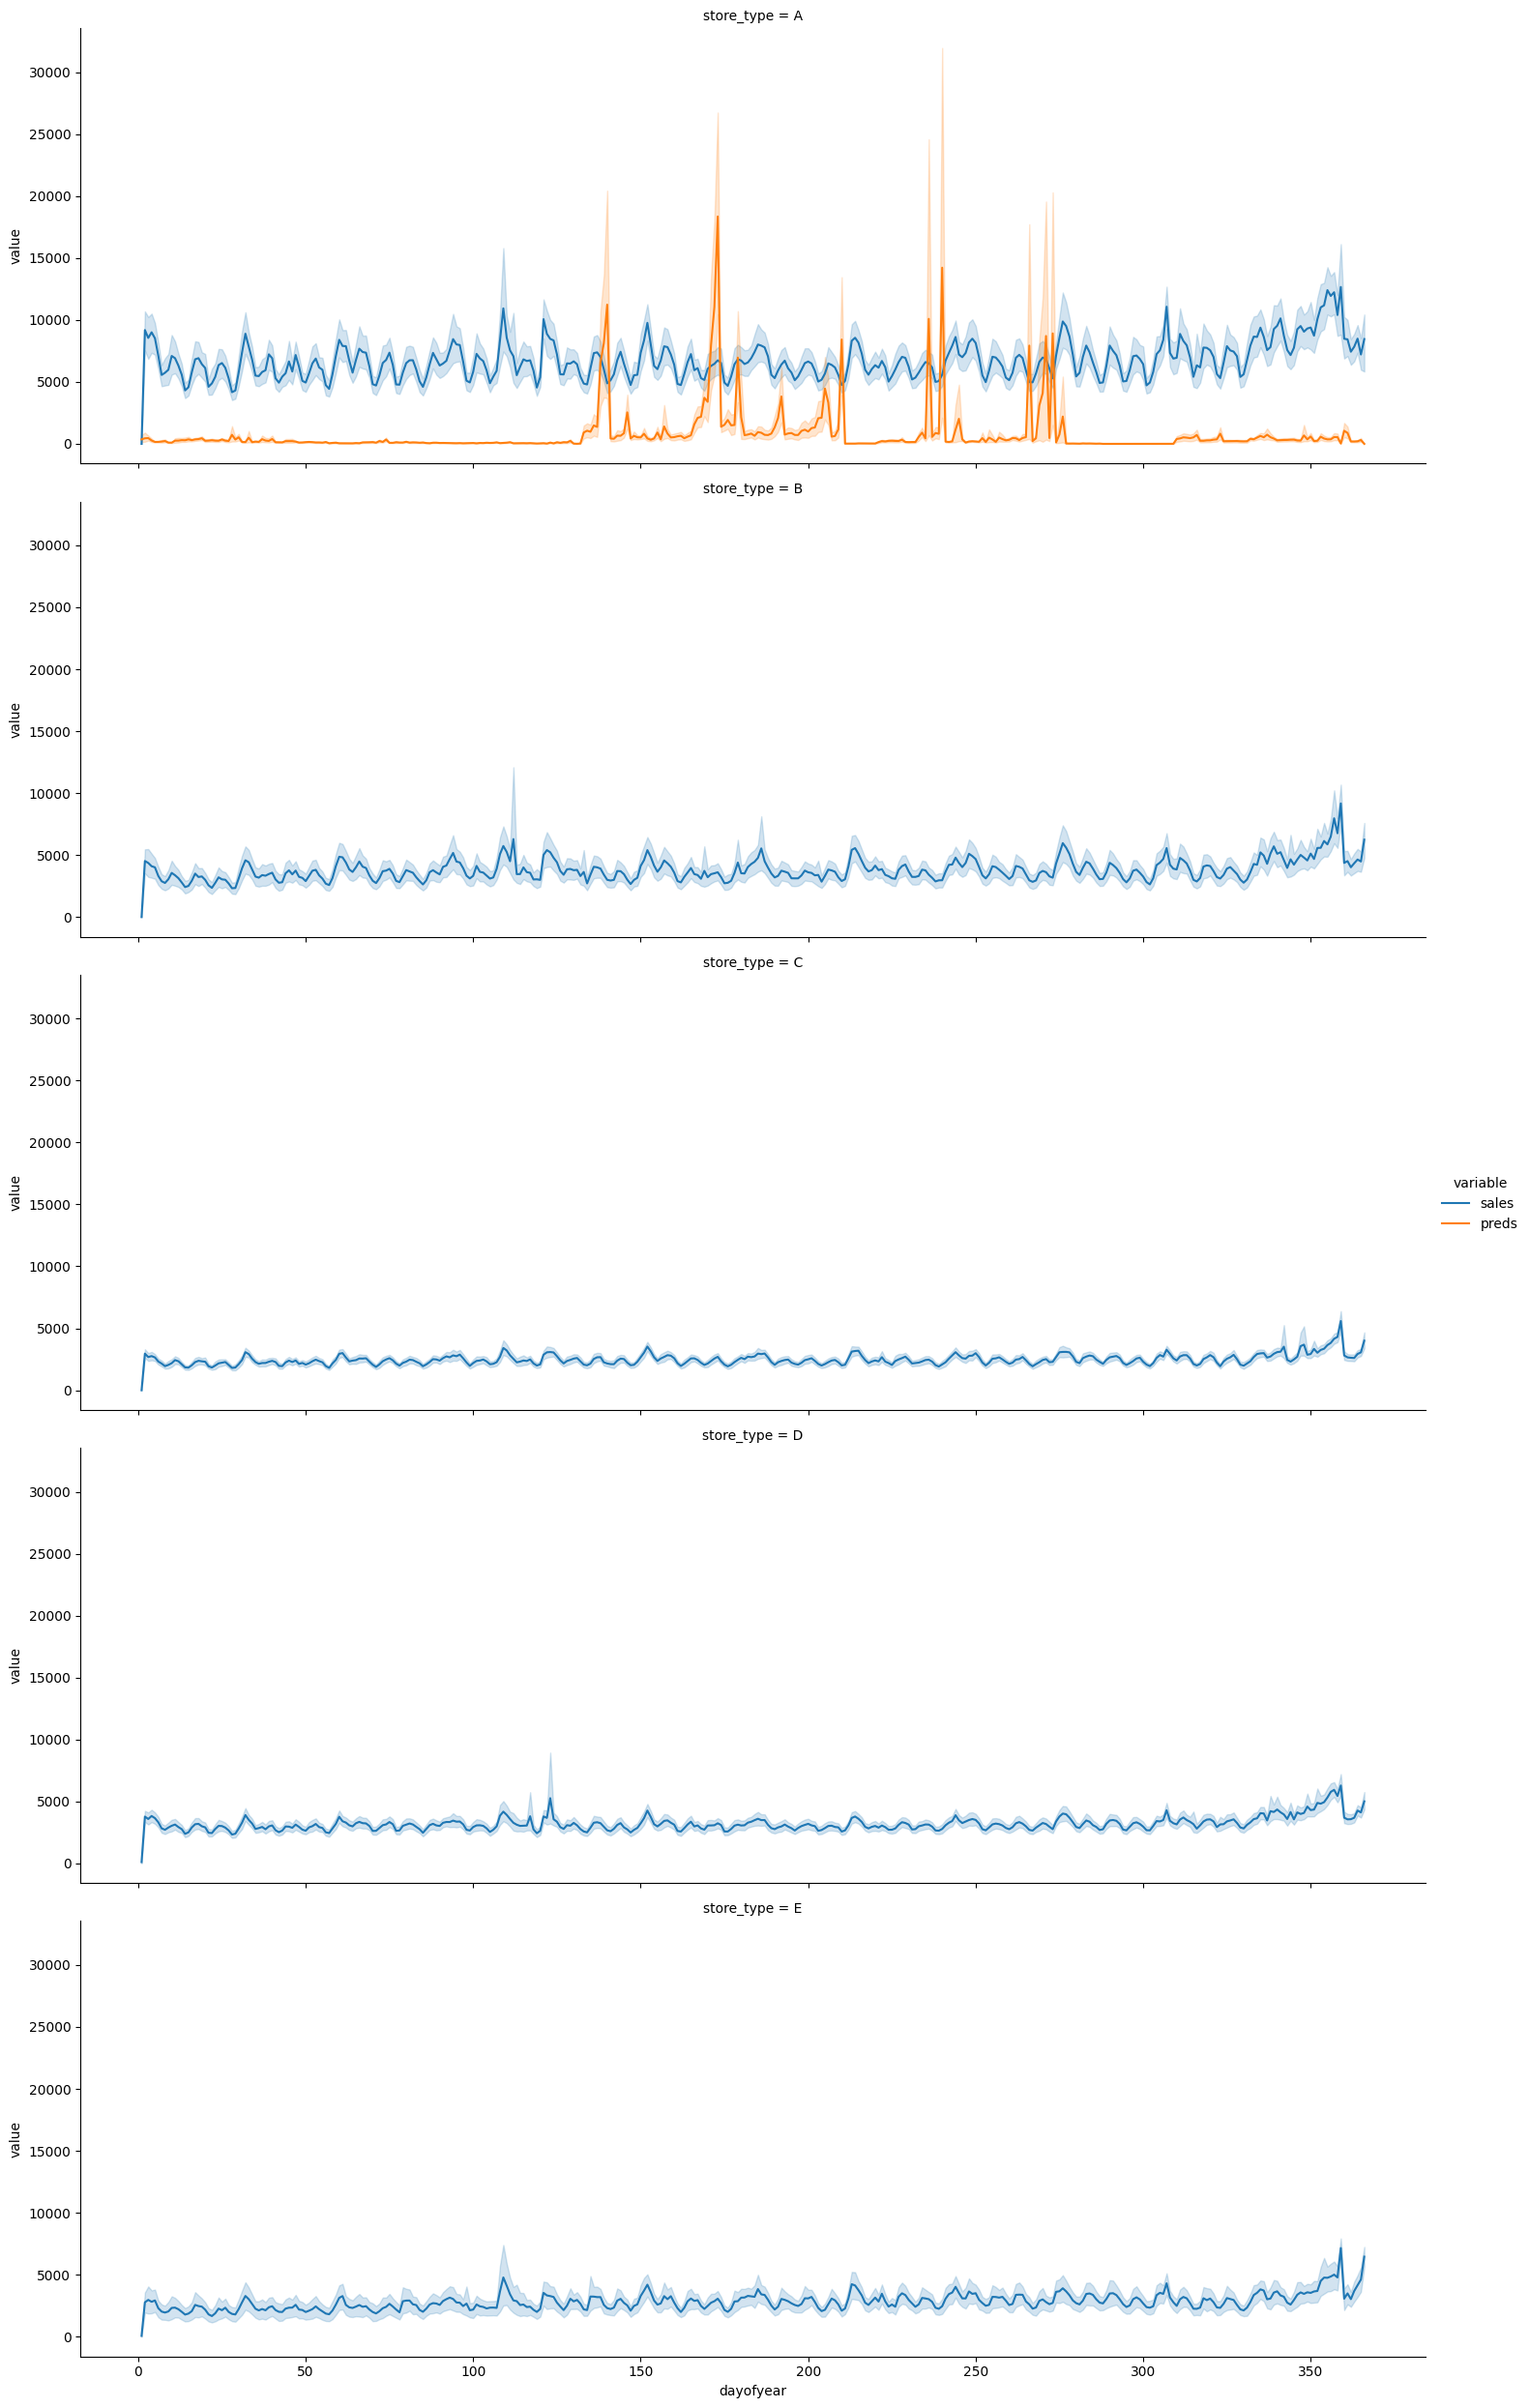

In [16]:
g = train.copy()
g['preds'] = y
g = g.query('family == "GROCERY I"')
g = g[['store_type', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_type', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='store_type', row_order=list('ABCDE')
            , kind='line', aspect=3);

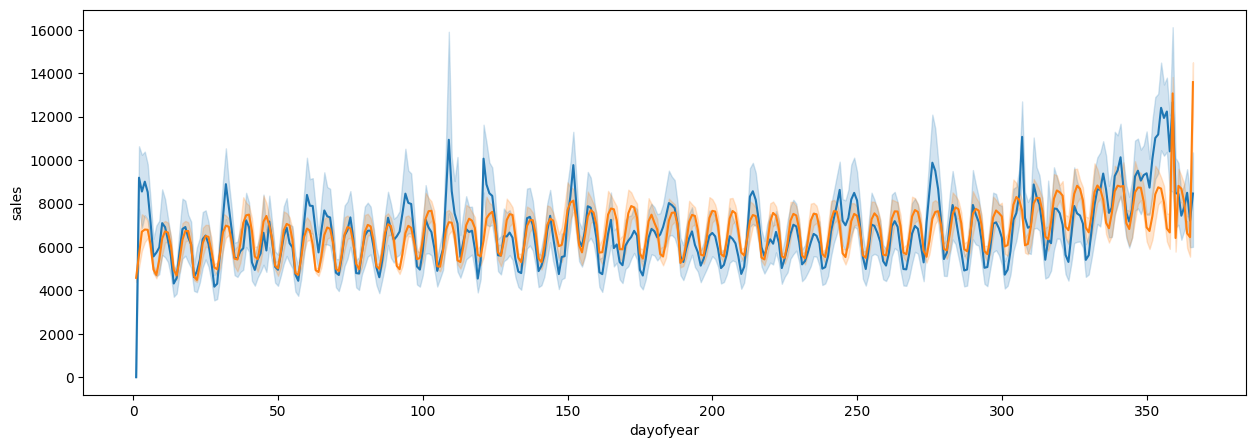

In [17]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

# → Questioning the zeros
Do I train the model without the zeros? Do I train each family and cluster separately?
Yes, you need to train the model for each family. And the zeros matter.

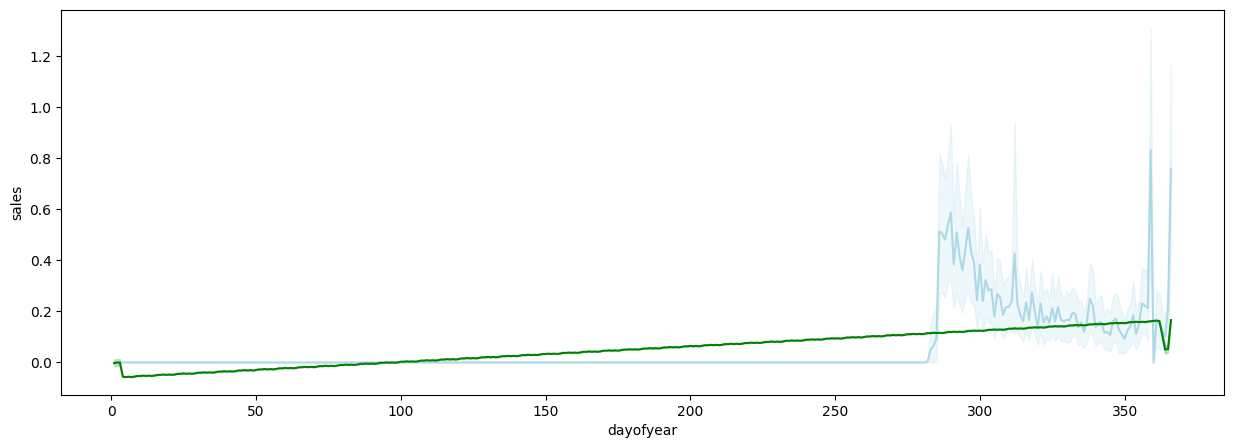

In [18]:
g = train
g['preds'] = y

g = g.query('family == "BOOKS"')
# g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds_nonzero'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
# sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='orange');
sns.lineplot(data=g, x='dayofyear', y='preds_nonzero', ax=ax, color='green');

# → Submission

In [19]:
# samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
# pd.DataFrame({
#     'id': samp['id']
#     , 'sales': reg_lin.predict(pipe.transform(samp))
# }).to_csv('submission.csv', index=False)